# Bridging the Gaps in LLM Interpretability of Unstructured Data with Knowledge Graphs
- Uses StrictJSON to parse the Knowledge Graph: https://github.com/tanchongmin/strictjson

# Import required packages

In [10]:
!pip install strictjson

In [11]:
from strictjson import *
import os
import openai
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [12]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = api_key

# Utility functions

In [13]:
def chat(system_prompt, user_prompt = '', model = 'gpt-4', temperature = 0, **kwargs):
    ''' This replies the user based on a system prompt and user prompt to call OpenAI Chat Completions API '''
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        temperature = temperature,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        **kwargs
    )
    res = response.choices[0].message.content
    return res

In [14]:
def plot_graph(kg):
    ''' Plots graph based on knowledge graph '''
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in kg)

    # Plot the graph
    plt.figure(figsize=(10,6), dpi=300)
    pos = nx.spring_layout(G, k=3, seed=0)

    nx.draw_networkx_nodes(G, pos, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Display the plot
    plt.axis('off')
    plt.show()

## Step 1: Generate knowledge graph from context

In [15]:
context ='''
The sun is about to act like your college roommate freshman year—it’s getting totally blacked out on a Monday afternoon.

A total solar eclipse will be visible across North America today, an event that won’t take place in the US again until 2044. The path of totality will cut through Middle America like a country music tour bus, allowing 30+ million people from Texas to Maine to see the sun, moon, and Earth align perfectly in the early afternoon.

Bigger than the Super Bowl and Taylor Swift
Americans are treating the eclipse like the YOLO moment it is and spending big: It’s projected to deliver a $6 billion infusion to the US economy—not far off the combined impact of Taylor Swift’s Eras Tour ($5.7 billion) and the 2023 Super Bowl ($1.3 billion). Millions are making a vacation out of it, shelling out for flights, hotels, and tickets to viewing parties along the path of totality. And cities big and small are at full capacity.

Indianapolis is preparing for 500,000 visitors—more than 7x the attendance of the Super Bowl it hosted in 2012.
Niagara Falls expects to host up to 1 million people for the eclipse. It typically gets 14 million visitors…throughout the entire year.
Brands are also cashing in: Companies are rolling out eclipse-themed promotions, such as Delta’s two flights that track the path of totality.

Scientists are amped
The people most excited about the eclipse are scientists, who for centuries have conducted experiments that can only be done in syzygy. While the moon is blacking out the sun for several minutes, they’ll be scrambling to gather data about the solar system and also observe how animals behave when day suddenly turns to night. Did you know that helium was discovered during the 1868 eclipse?

Enjoy it while you can. With the moon moving away from Earth at a rate of 1.5 inches per year, total eclipses will eventually become a thing of the past in about 600 million years, according to Johns Hopkins professor Sabine Stanley.
'''

In [16]:
res = strict_json(system_prompt = '''You are a knowledge graph builder. 
You are to output relations between two objects in the form (object_1, relation, object_2). 
All information about dates must be included.
Example Input: John bought a laptop
Example Output: [('John', 'bought', 'laptop')]
Example Input: John built a house in 2019
Example Output: [('John', 'built', 'house'), ('house', 'built in', '2019')]''',
                    user_prompt = context,
                    output_format = {"List of triplets": "List of triplets of the form (object_1, relation, object_2), type: list"})
print(res)

{'List of triplets': [('sun', 'about to act like', 'college roommate freshman year'), ('total solar eclipse', 'visible across', 'North America'), ('total solar eclipse', 'take place in', 'US'), ('path of totality', 'cut through', 'Middle America'), ('30+ million people', 'able to see', 'sun, moon, and Earth align perfectly'), ('eclipse', 'treated like', 'YOLO moment'), ('eclipse', 'projected to deliver', '$6 billion infusion to US economy'), ('millions', 'making', 'vacation out of it'), ('cities big and small', 'at', 'full capacity'), ('Indianapolis', 'preparing for', '500,000 visitors'), ('Niagara Falls', 'expects to host', 'up to 1 million people'), ('Niagara Falls', 'typically gets', '14 million visitors throughout the entire year'), ('companies', 'rolling out', 'eclipse-themed promotions'), ('scientists', 'most excited about', 'eclipse'), ('scientists', 'conducting experiments during', 'syzygy'), ('helium', 'discovered during', '1868 eclipse'), ('moon', 'moving away from', 'Earth a

In [17]:
kg = res['List of triplets']

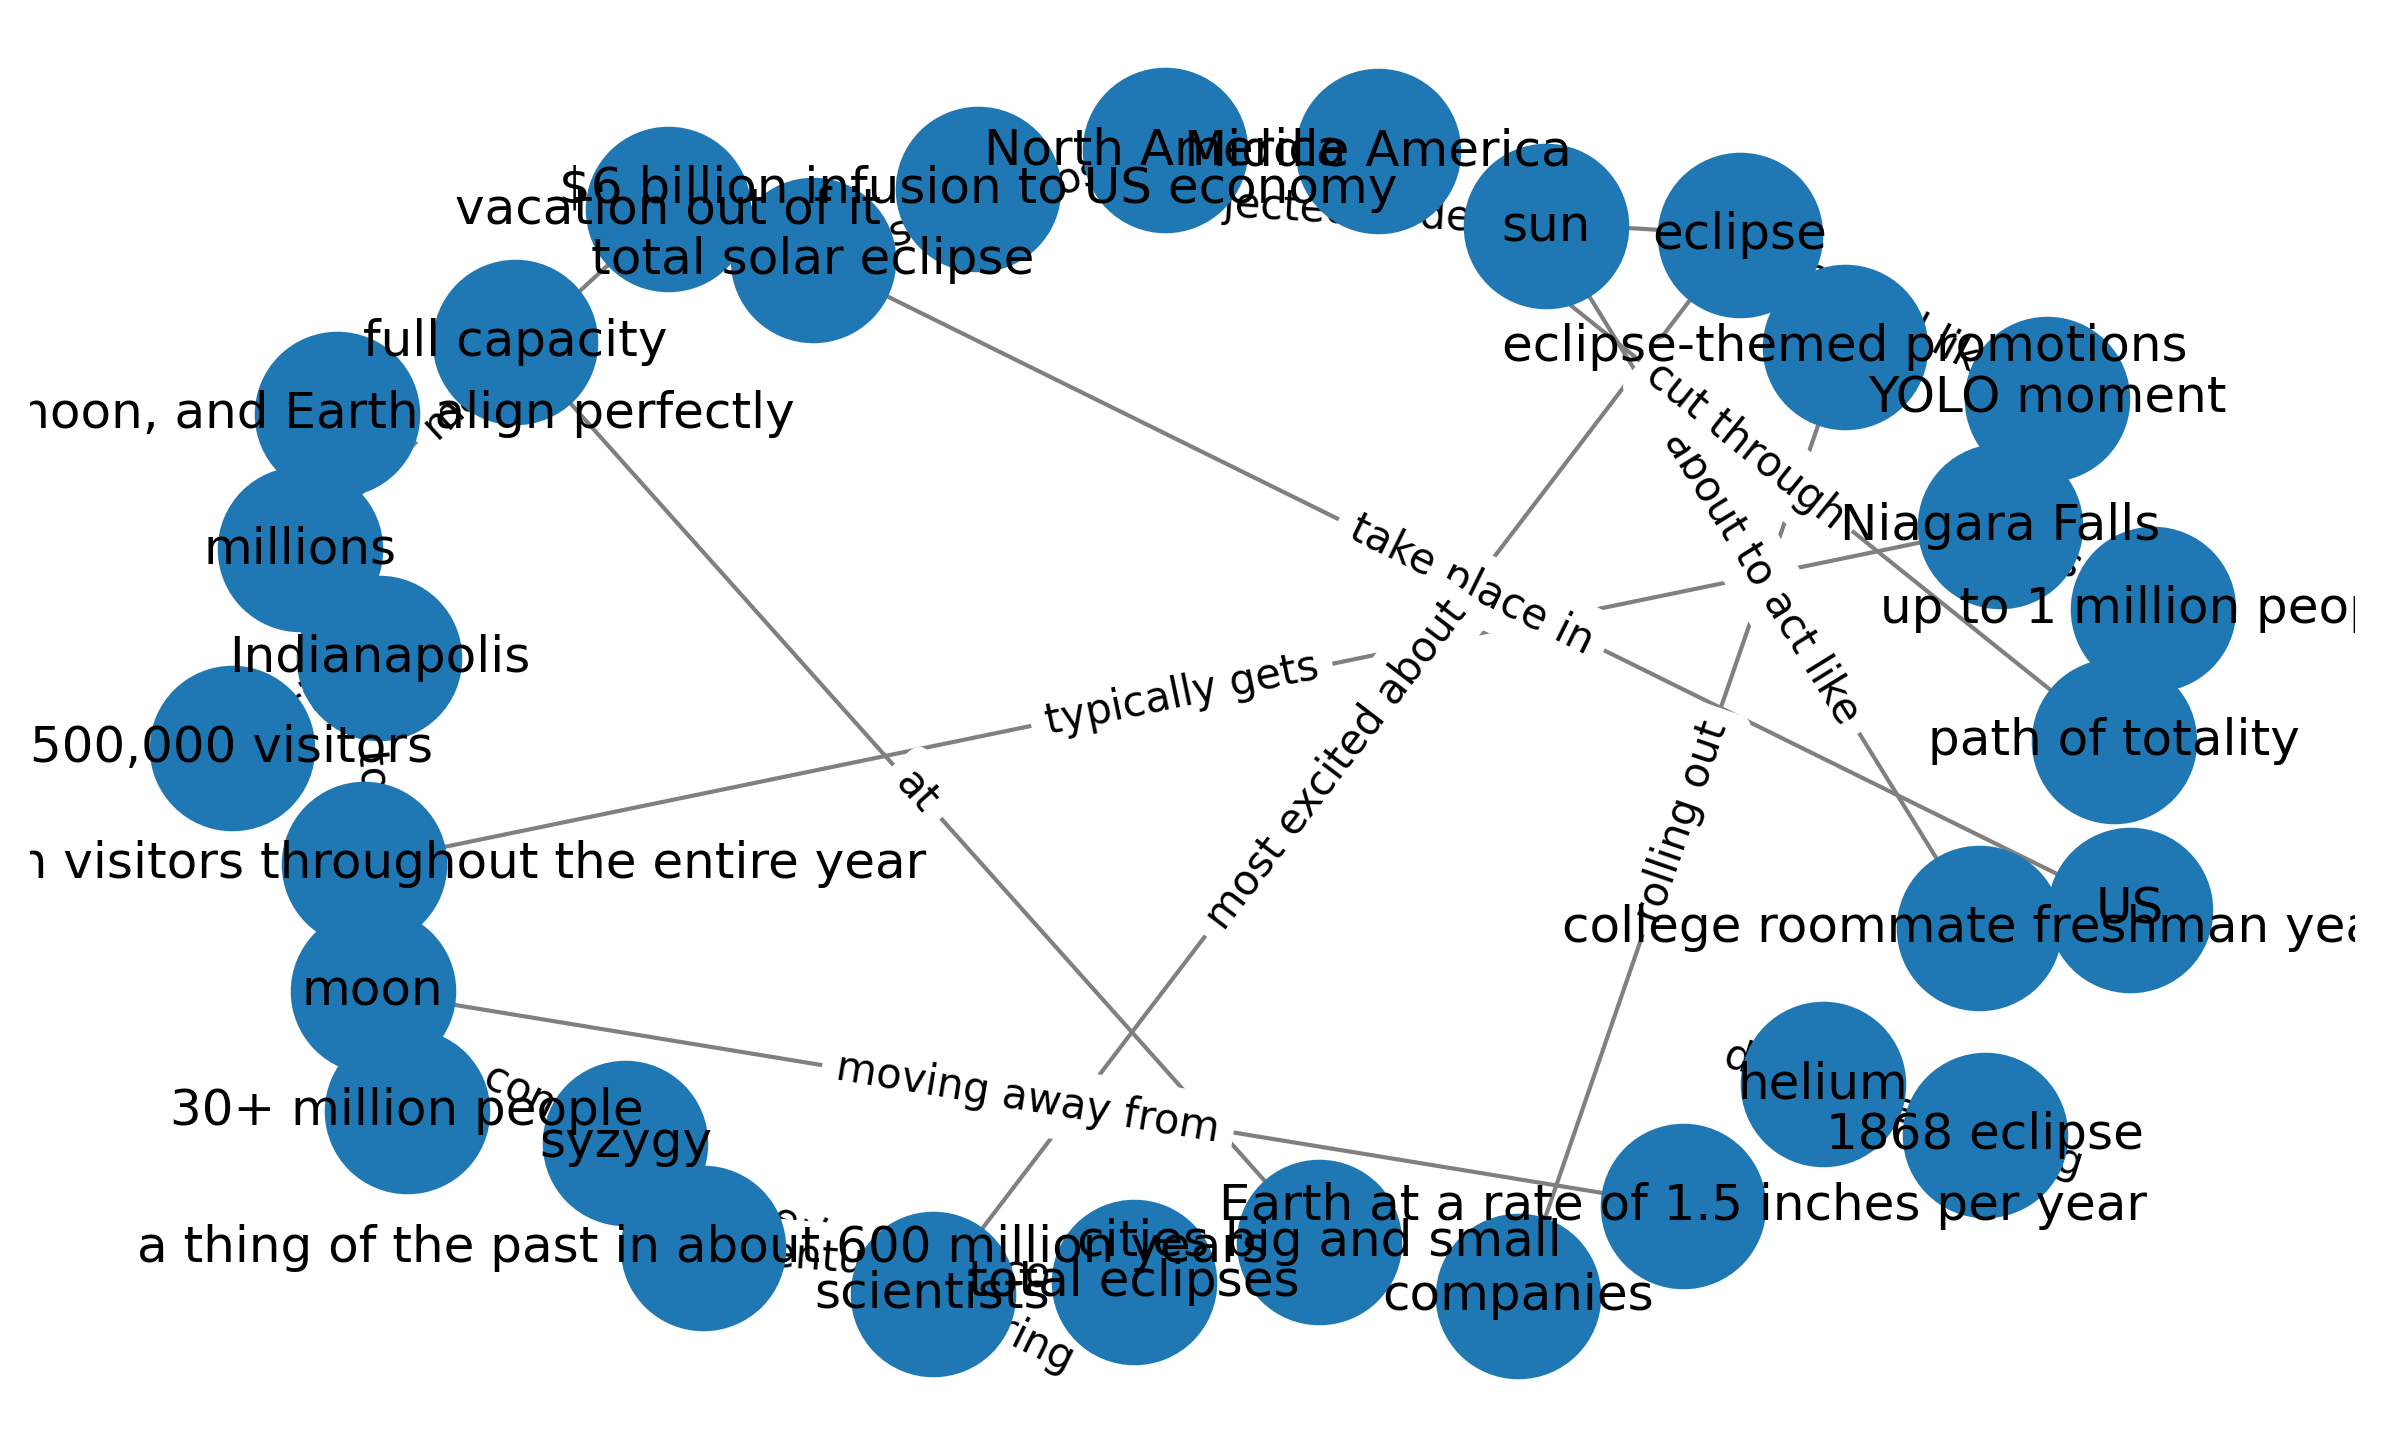

In [18]:
plot_graph(kg)

# Step 2: Parse Knowledge Graph
- Retrieve only triplets that are relevant to the question by using GPT to parse through
- Can also do by cosine similarity, or entity matching, though performance may be worse off

In [19]:
question = "What is the significance of the solar eclipse?"

In [20]:
res = strict_json(system_prompt = f'''You are a knowledge graph parser. 
Only output the triplets that are relevant to the question.
Knowledge Graph: {kg}''',
                    user_prompt = f'''Question: {question}''',
                    output_format = {"Parsed Knowledge Graph": "List of triplets of the form (object1, relation, object2), type: list"})
print(res)

{'Parsed Knowledge Graph': [('eclipse', 'treated like', 'YOLO moment'), ('eclipse', 'projected to deliver', '$6 billion infusion to US economy'), ('scientists', 'most excited about', 'eclipse'), ('scientists', 'conducting experiments during', 'syzygy'), ('helium', 'discovered during', '1868 eclipse')]}


In [21]:
parsed_kg = res['Parsed Knowledge Graph']

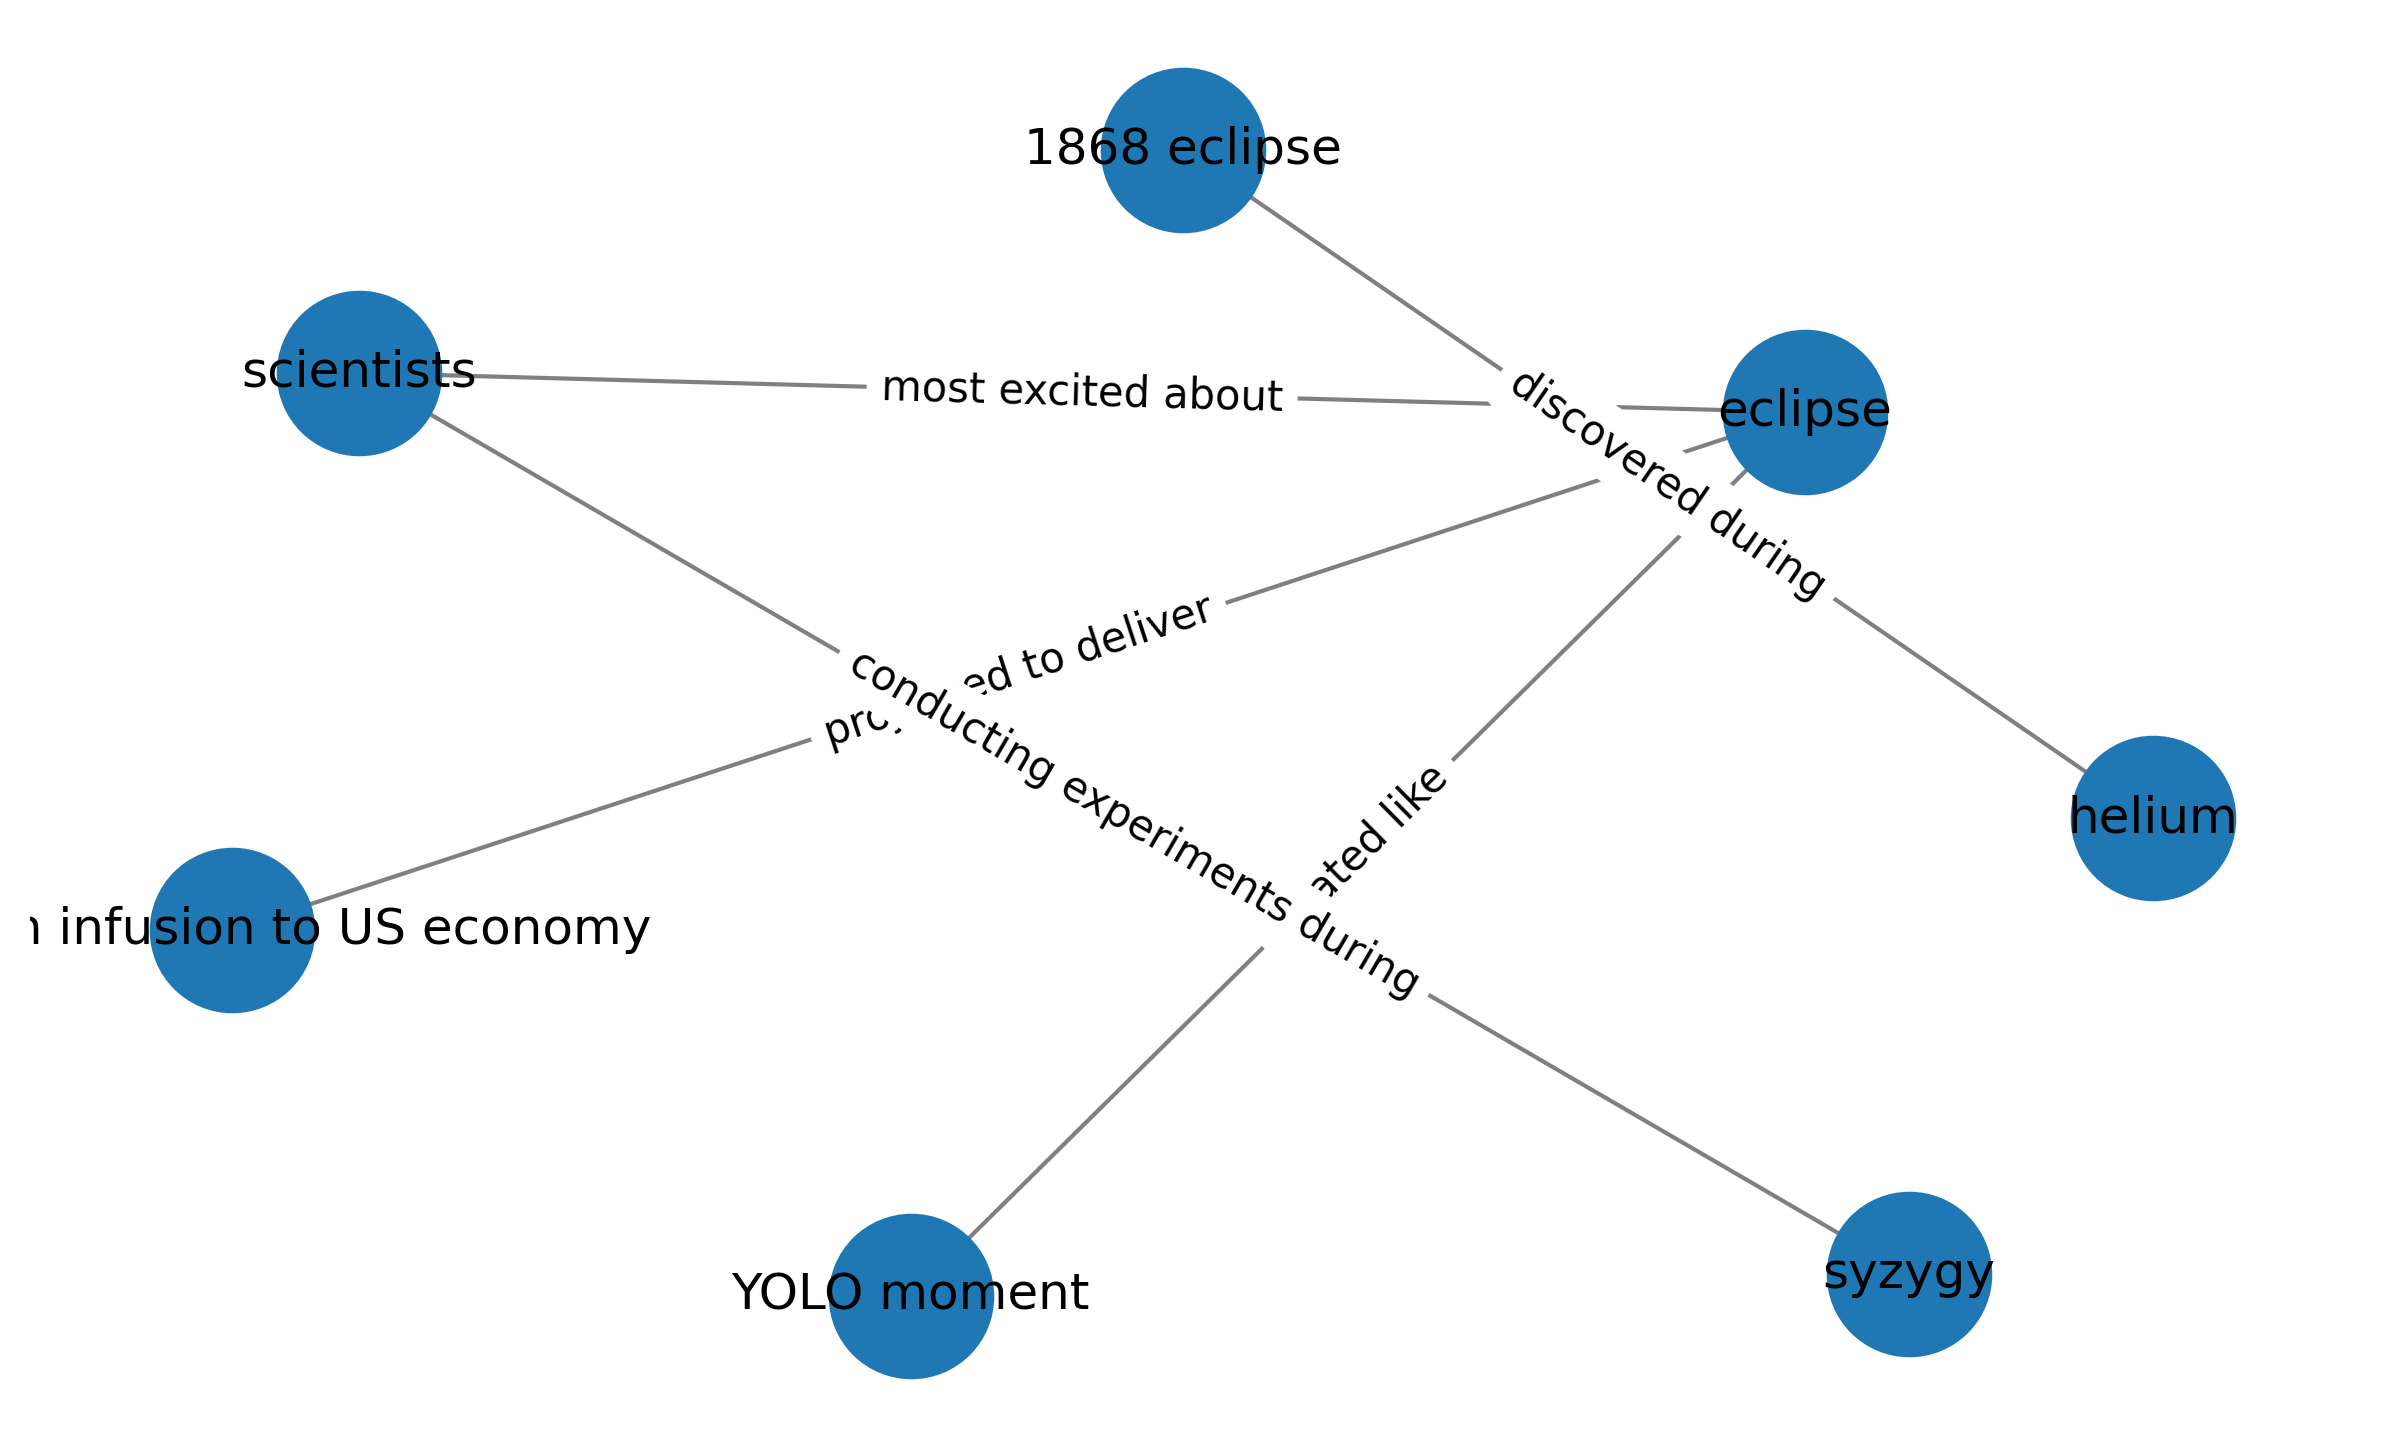

In [22]:
plot_graph(parsed_kg)

# Step 3: Use Parsed Knowledge Graph to Answer Question

In [23]:
res = strict_json(system_prompt = f'''Use the knowledge graph to answer the following question. 
If you are unsure, output 'No Info'
Knowledge Graph: {parsed_kg}''',
                    user_prompt = f'''Question: {question}''',
                    output_format = {"Answer": "Answer question using knowledge graph"})
print('Question:', question)
print('Answer with Parsed Knowledge Graph:', res['Answer'])

Question: What is the significance of the solar eclipse?
Answer with Parsed Knowledge Graph: Scientists are most excited about the eclipse and it is projected to deliver a $6 billion infusion to the US economy.


In [24]:
print('Question:', question)
print('GPT4-enhanced answer with Parsed Knowledge Graph:', chat(f'''Use the knowledge graph to answer the following question. 
If you are unsure, output 'No Info'
Knowledge Graph: {parsed_kg}''',
                    user_prompt = f'''Question: {question}'''))

Question: What is the significance of the solar eclipse?
GPT4-enhanced answer with Parsed Knowledge Graph: The solar eclipse is significant as it is treated like a YOLO moment and is projected to deliver a $6 billion infusion to the US economy. It is also an event that scientists are most excited about.


In [25]:
print('Question:', question)
print('Answer with in-prompt context:', chat(f"Context: {context}\nQuestion: {question}"))

Question: What is the significance of the solar eclipse?
Answer with in-prompt context: The solar eclipse is significant for several reasons. Economically, it is projected to deliver a $6 billion infusion to the US economy as millions of people are making a vacation out of it, spending on flights, hotels, and tickets to viewing parties. Cities and brands are also cashing in on the event with increased capacity and eclipse-themed promotions. Scientifically, the eclipse provides a unique opportunity for scientists to conduct experiments and gather data about the solar system, as well as observe how animals behave when day suddenly turns to night. It's also a rare event that won't take place in the US again until 2044, adding to its significance.
